# ***Import all necessary Libraries***

In [1]:
# Install necessary libraries
!pip install tensorflow keras
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
!pip install adversarial-robustness-toolbox==1.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


# ***Load the dataset from the drive***

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths on Google Drive
# Replace `your-folder-path` with the actual path where train, val, and test folders are stored
train_dir = '/content/drive/My Drive/malimg_dataset/train'
val_dir = '/content/drive/My Drive/malimg_dataset/val'
test_dir = '/content/drive/My Drive/malimg_dataset/test'


Mounted at /content/drive


# ***Preprocessing the data***

In [4]:
# Preprocessing the data
input_shape = (128, 128, 3)  # Adjust based on Malimg dataset resolution
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0 / 255)

train_data = datagen.flow_from_directory(train_dir, target_size=input_shape[:2], batch_size=batch_size, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=input_shape[:2], batch_size=batch_size, class_mode='categorical')
test_data = datagen.flow_from_directory(test_dir, target_size=input_shape[:2], batch_size=batch_size, class_mode='categorical')

Found 7459 images belonging to 25 classes.
Found 923 images belonging to 25 classes.
Found 957 images belonging to 25 classes.


# ***Training the model and evaluting on the test set***

In [ ]:
# Build ResNet model
base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(train_data.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 3  # Adjust for accuracy; increase if needed
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Accuracy on clean test images: {test_accuracy * 100:.2f}%")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(train_data.class_indices),
    input_shape=(128, 128, 3),
    clip_values=(0, 1),  # Normalized input range
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

# ***ZOO Attack***

ZOO:   0%|          | 0/5 [00:00<?, ?it/s]

Attack Success Rate (ZOO): 40.00%
Adversarial Accuracy (ZOO): 60.00%


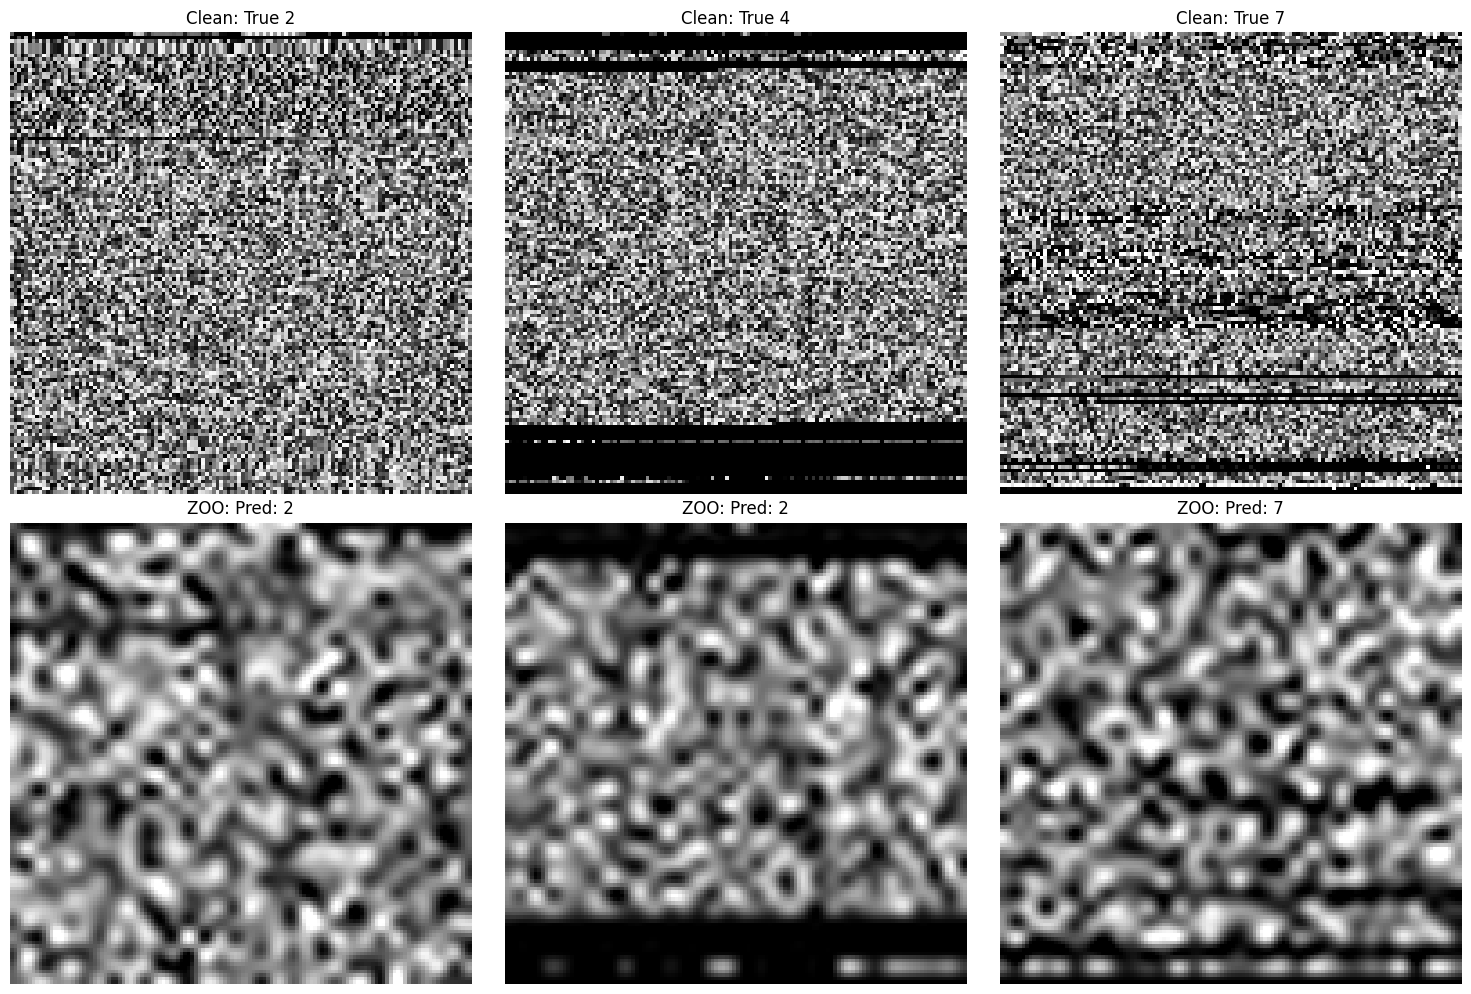

In [ ]:
# Perform ZOO Attack
zoo_attack = ZooAttack(
    classifier=classifier,
    confidence=0.0,
    targeted=False,
    learning_rate=1e-1,   # Keep learning rate moderate
    max_iter=1,           # Minimize iterations for faster computation
    binary_search_steps=3,  # Reduce binary search steps for efficiency
    initial_const=1e-3,
    abort_early=True      # Enable early stopping for quicker results
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:5], y_test[:5]  # Attack a smaller subset (5 samples)

# Generate Adversarial Examples
zoo_adv_images = zoo_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
zoo_adv_predictions = classifier.predict(zoo_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
zoo_adv_labels = np.argmax(zoo_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
zoo_success_rate = np.mean(zoo_adv_labels != true_labels) * 100
zoo_adv_accuracy = np.mean(zoo_adv_labels == true_labels) * 100

print(f"Attack Success Rate (ZOO): {zoo_success_rate:.2f}%")
print(f"Adversarial Accuracy (ZOO): {zoo_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit to 3 samples for clarity
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"ZOO: Pred: {zoo_adv_labels[i]}")
    plt.imshow(zoo_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


# ***BIM Attack***

PGD - Batches: 0it [00:00, ?it/s]

Attack Success Rate (BIM): 70.00%
Adversarial Accuracy (BIM): 30.00%


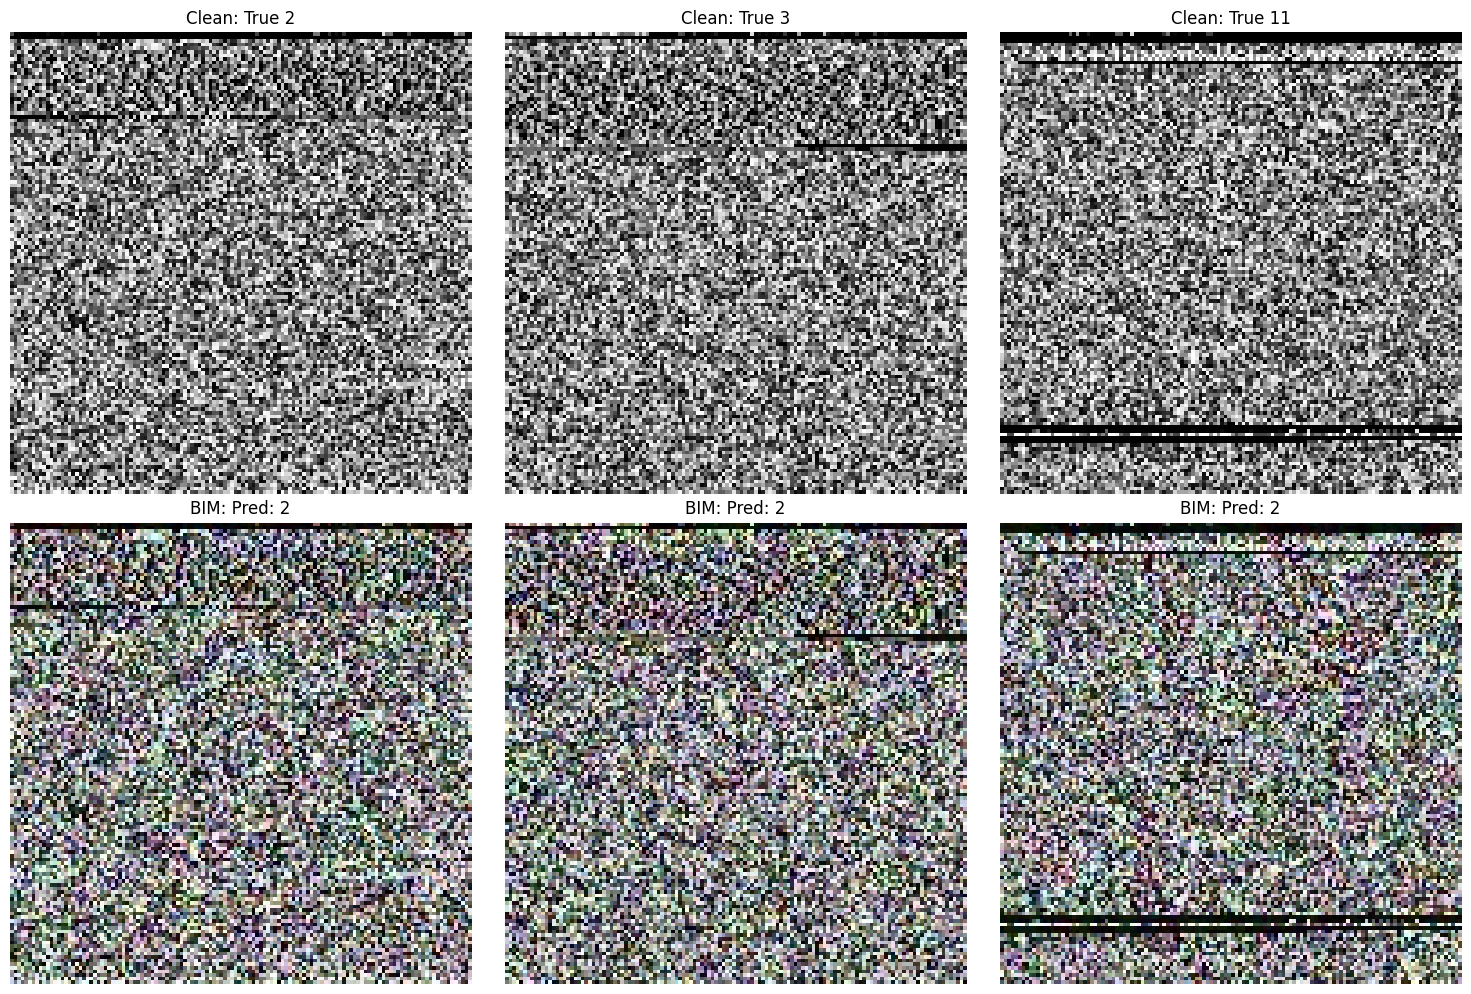

In [ ]:
from art.attacks.evasion import BasicIterativeMethod

# Perform BIM Attack
bim_attack = BasicIterativeMethod(
    estimator=classifier,
    eps=0.1,              # Maximum perturbation (epsilon)
    eps_step=0.01,        # Step size for each iteration
    max_iter=30,          # Number of attack iterations
    targeted=False        # Untargeted attack
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:10], y_test[:10]  # Attack a smaller subset (5 samples)

# Generate Adversarial Examples
bim_adv_images = bim_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
bim_adv_predictions = classifier.predict(bim_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
bim_adv_labels = np.argmax(bim_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
bim_success_rate = np.mean(bim_adv_labels != true_labels) * 100
bim_adv_accuracy = np.mean(bim_adv_labels == true_labels) * 100

print(f"Attack Success Rate (BIM): {bim_success_rate:.2f}%")
print(f"Adversarial Accuracy (BIM): {bim_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit to 3 samples for clarity
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"BIM: Pred: {bim_adv_labels[i]}")
    plt.imshow(bim_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


PGD - Batches: 0it [00:00, ?it/s]

Attack Success Rate (BIM): 90.00%
Adversarial Accuracy (BIM): 10.00%


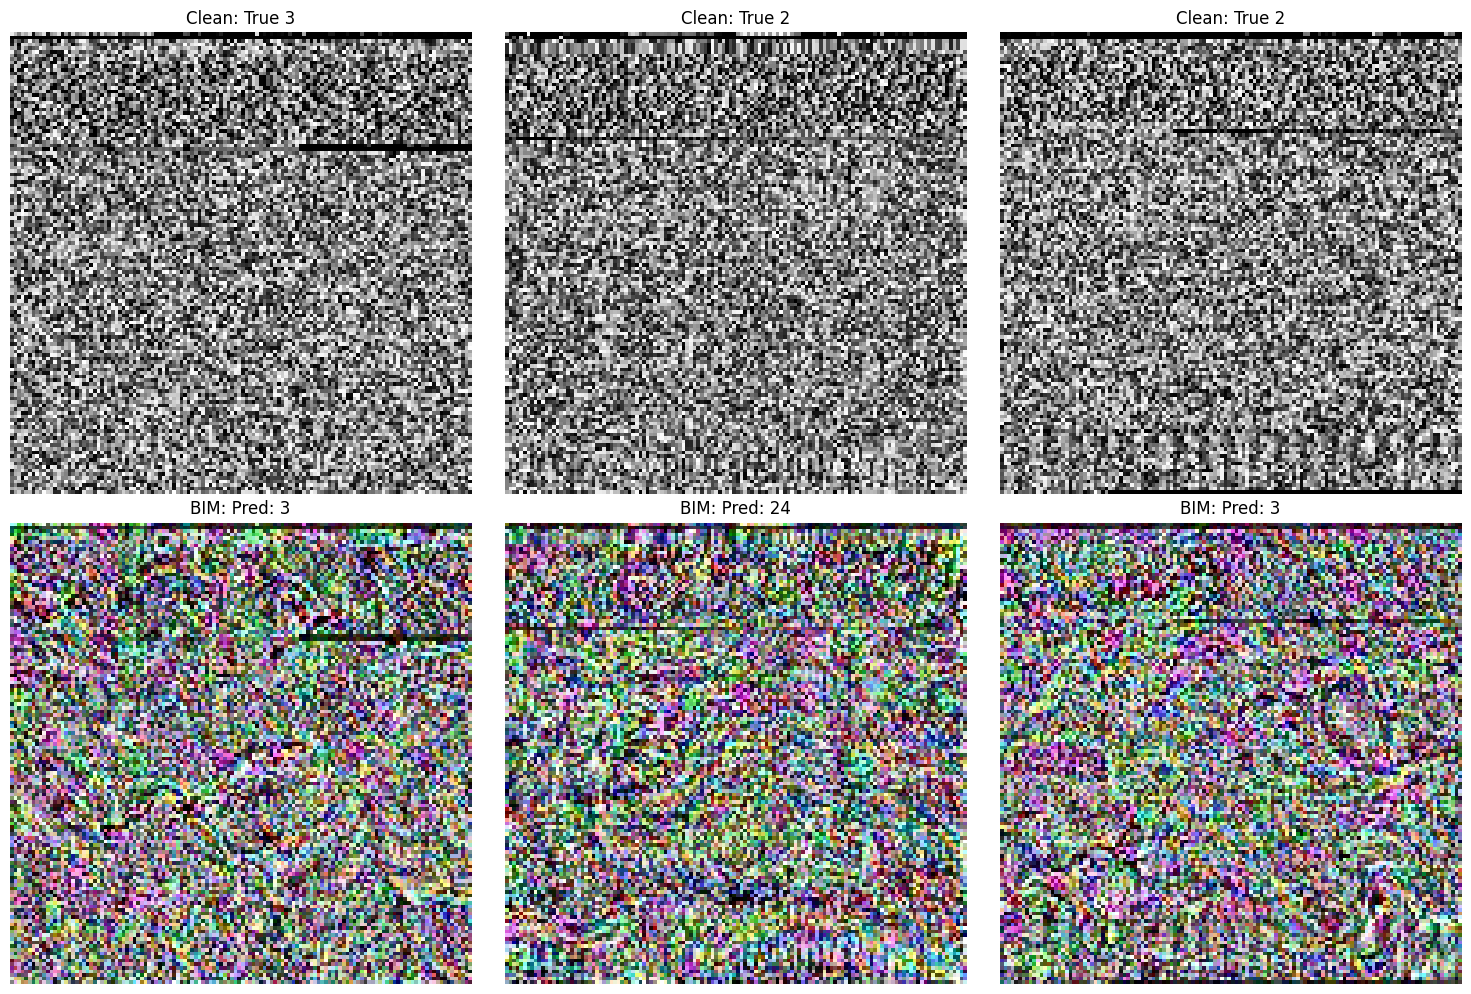

In [ ]:
from art.attacks.evasion import BasicIterativeMethod

# --- Perform Stronger BIM Attack ---
bim_attack = BasicIterativeMethod(
    estimator=classifier,
    eps=0.3,              # Higher maximum perturbation
    eps_step=0.05,        # Larger step size per iteration
    max_iter=50,          # Increased number of iterations
    targeted=False        # Untargeted attack
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:10], y_test[:10]  # Attack a smaller subset (10 samples)

# Generate Adversarial Examples
bim_adv_images = bim_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
bim_adv_predictions = classifier.predict(bim_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
bim_adv_labels = np.argmax(bim_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
bim_success_rate = np.mean(bim_adv_labels != true_labels) * 100
bim_adv_accuracy = np.mean(bim_adv_labels == true_labels) * 100

print(f"Attack Success Rate (BIM): {bim_success_rate:.2f}%")
print(f"Adversarial Accuracy (BIM): {bim_adv_accuracy:.2f}%")

# --- Visualize Clean and Adversarial Images ---
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit to 3 samples for clarity
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"BIM: Pred: {bim_adv_labels[i]}")
    plt.imshow(bim_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


More Subset

PGD - Batches: 0it [00:00, ?it/s]

Attack Success Rate (BIM): 84.38%
Adversarial Accuracy (BIM): 15.62%


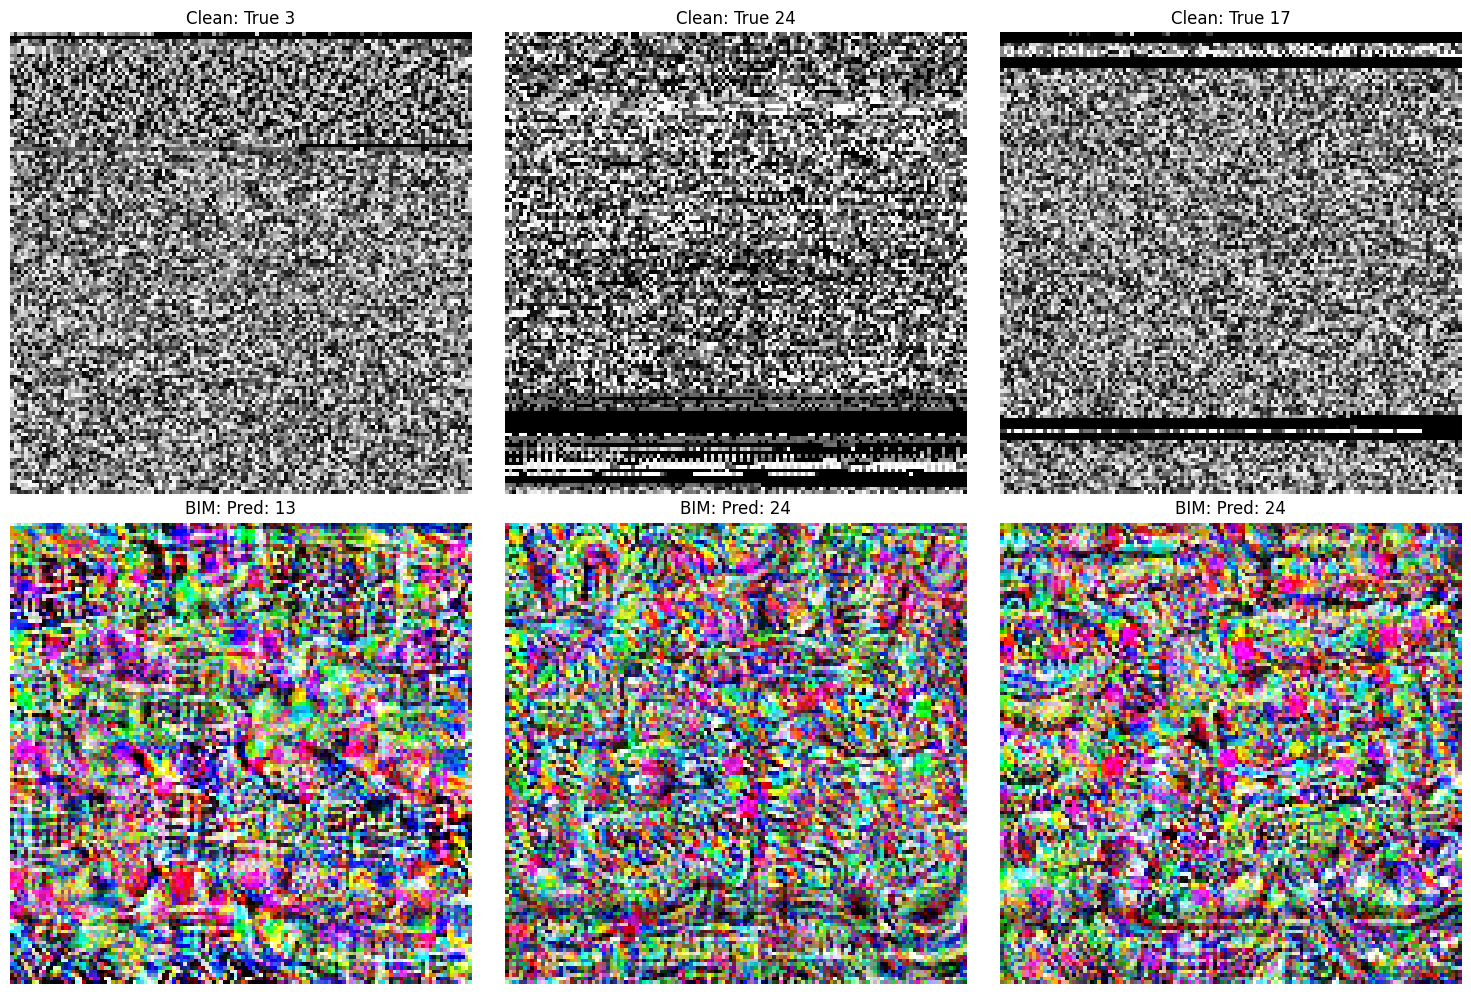

In [ ]:
from art.attacks.evasion import BasicIterativeMethod

# --- Perform More Aggressive BIM Attack ---
bim_attack = BasicIterativeMethod(
    estimator=classifier,
    eps=0.8,              # Significantly higher maximum perturbation
    eps_step=0.1,         # Larger step size per iteration
    max_iter=100,         # Increased number of iterations
    targeted=False        # Untargeted attack
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:100], y_test[:100]  # Use a larger subset for evaluation

# Generate Adversarial Examples
bim_adv_images = bim_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
bim_adv_predictions = classifier.predict(bim_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
bim_adv_labels = np.argmax(bim_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
bim_success_rate = np.mean(bim_adv_labels != true_labels) * 100
bim_adv_accuracy = np.mean(bim_adv_labels == true_labels) * 100

print(f"Attack Success Rate (BIM): {bim_success_rate:.2f}%")
print(f"Adversarial Accuracy (BIM): {bim_adv_accuracy:.2f}%")

# --- Visualize Clean and Adversarial Images ---
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit to 3 samples for clarity
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"BIM: Pred: {bim_adv_labels[i]}")
    plt.imshow(bim_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


# *JSMA Attack*

<ipython-input-7-264989af02b1>:17: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  jsma_adv_images = jsma_attack.generate(x=x_test_subset)


JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

Attack Success Rate (JSMA): 80.00%
Adversarial Accuracy (JSMA): 20.00%


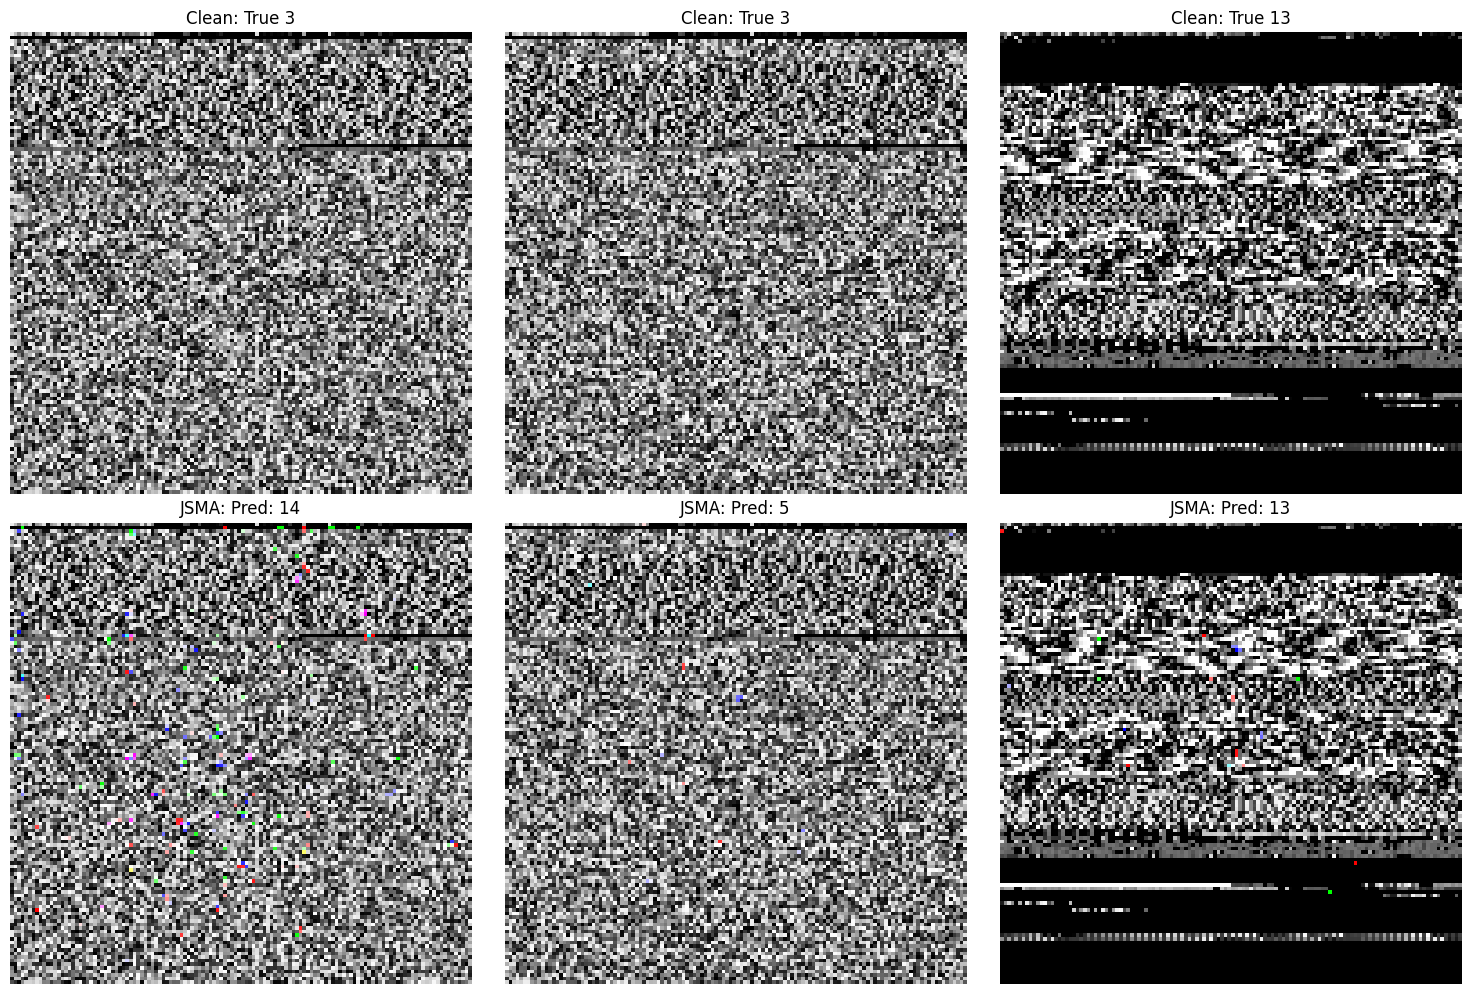

In [ ]:
from art.attacks.evasion import SaliencyMapMethod

# Perform JSMA Attack
jsma_attack = SaliencyMapMethod(
    classifier=classifier,
    theta=1.0,               # Perturbation step (positive or negative pixel changes)
    gamma=0.1,               # Fraction of pixels to modify (controls sparsity of attack)
    batch_size=1,            # Batch size for the attack (JSMA processes one sample at a time)
    verbose=True             # Display progress of the attack
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:5], y_test[:5]  # Attack a smaller subset (5 samples)

# Generate Adversarial Examples
jsma_adv_images = jsma_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
jsma_adv_predictions = classifier.predict(jsma_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
jsma_adv_labels = np.argmax(jsma_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
jsma_success_rate = np.mean(jsma_adv_labels != true_labels) * 100
jsma_adv_accuracy = np.mean(jsma_adv_labels == true_labels) * 100

print(f"Attack Success Rate (JSMA): {jsma_success_rate:.2f}%")
print(f"Adversarial Accuracy (JSMA): {jsma_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit to 3 samples for clarity
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"JSMA: Pred: {jsma_adv_labels[i]}")
    plt.imshow(jsma_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


More Subset

<ipython-input-5-575c39463835>:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  jsma_adv_images = jsma_attack.generate(x=x_test_subset)


JSMA:   0%|          | 0/32 [00:00<?, ?it/s]

Attack Success Rate (JSMA): 93.75%
Adversarial Accuracy (JSMA): 6.25%


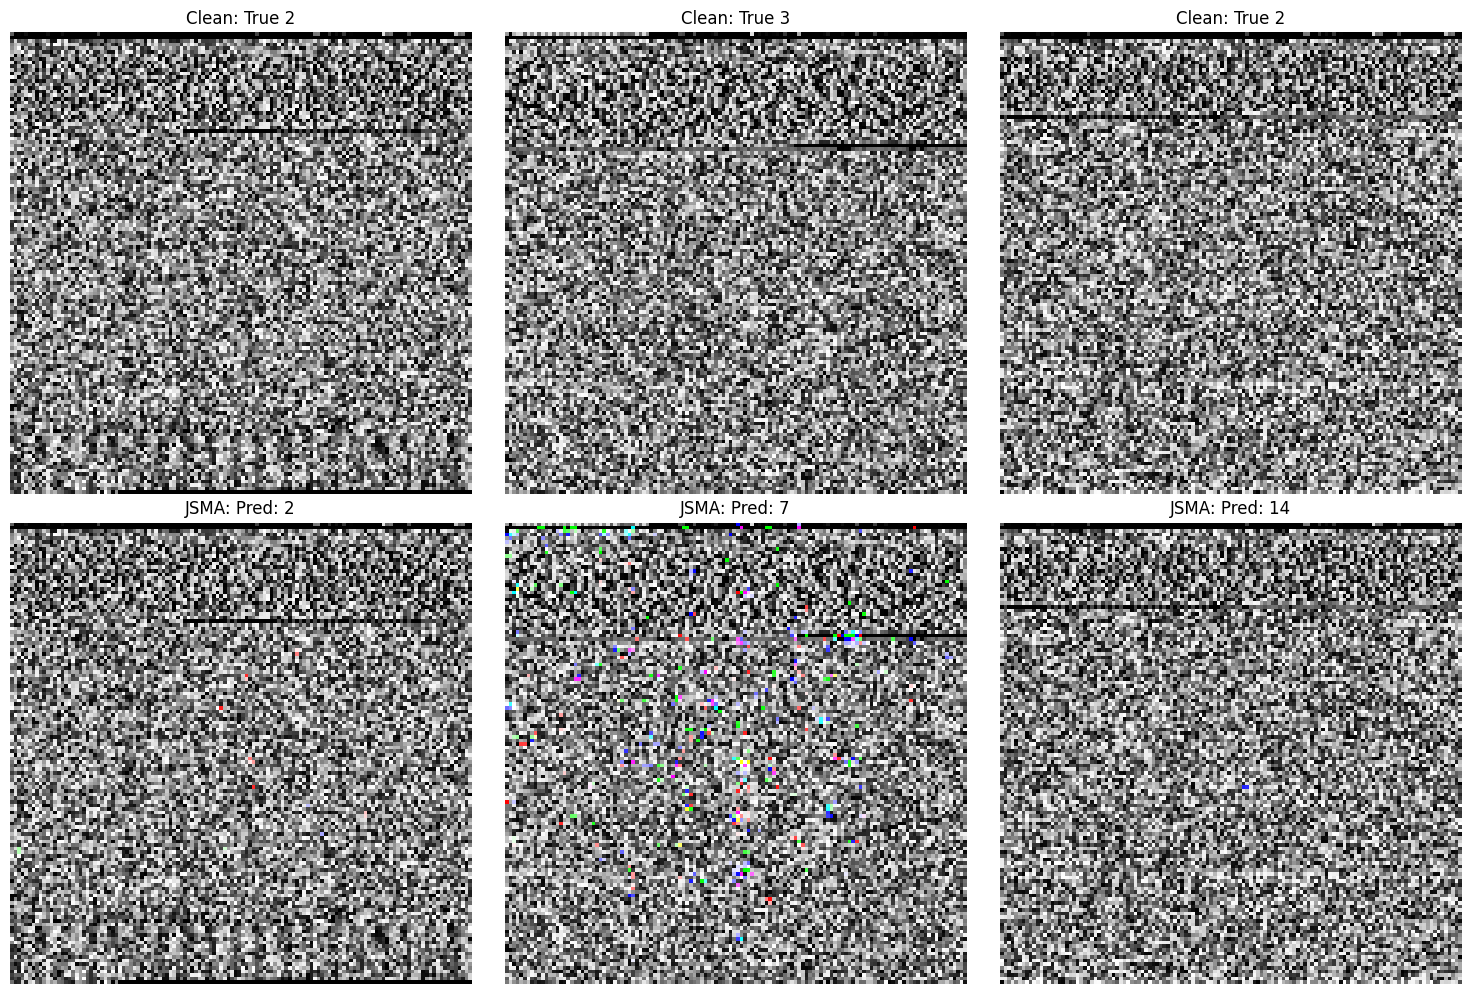

In [ ]:
from art.attacks.evasion import SaliencyMapMethod
import numpy as np
import matplotlib.pyplot as plt

# Perform a More Aggressive JSMA Attack
jsma_attack = SaliencyMapMethod(
    classifier=classifier,
    theta=1.5,               # Larger perturbation step to create more impactful changes
    gamma=0.3,               # Increase fraction of pixels modified for higher attack success
    batch_size=1,            # Batch size for the attack (JSMA processes one sample at a time)
    verbose=True             # Display progress of the attack
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:100], y_test[:100]  # Use a subset of 100 samples

# Generate Adversarial Examples
jsma_adv_images = jsma_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
jsma_adv_predictions = classifier.predict(jsma_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
jsma_adv_labels = np.argmax(jsma_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
jsma_success_rate = np.mean(jsma_adv_labels != true_labels) * 100
jsma_adv_accuracy = np.mean(jsma_adv_labels == true_labels) * 100

print(f"Attack Success Rate (JSMA): {jsma_success_rate:.2f}%")
print(f"Adversarial Accuracy (JSMA): {jsma_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit to 3 samples for clarity
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"JSMA: Pred: {jsma_adv_labels[i]}")
    plt.imshow(jsma_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


# ***Salt and Pepper***

Attack Success Rate (Salt-and-Pepper Noise): 60.00%
Adversarial Accuracy (Salt-and-Pepper Noise): 40.00%


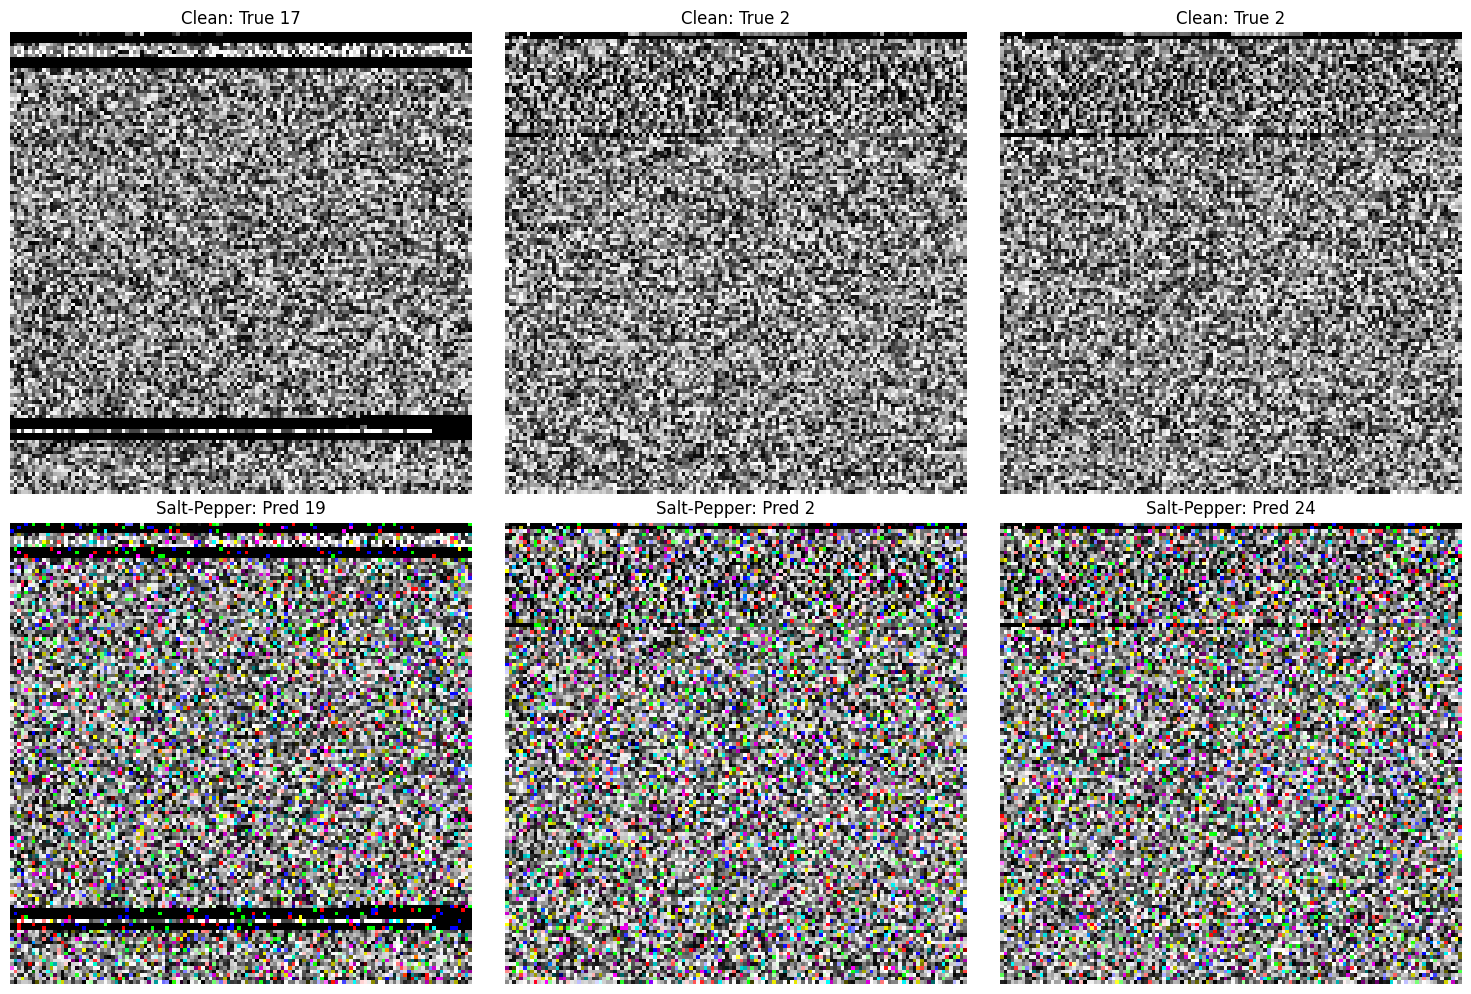

In [ ]:
import numpy as np

def add_salt_pepper_noise(x, noise_ratio=0.1):
    """
    Add Salt-and-Pepper noise to the input data.

    Parameters:
    - x: Input data (numpy array of shape [batch_size, height, width, channels]).
    - noise_ratio: Fraction of pixels to perturb with noise.

    Returns:
    - Perturbed data with salt-and-pepper noise.
    """
    perturbed_data = x.copy()
    batch_size, height, width, channels = x.shape
    num_pixels = int(noise_ratio * height * width * channels)  # Total pixels to perturb

    for i in range(batch_size):
        # Get random pixel indices to perturb
        for _ in range(num_pixels):
            row = np.random.randint(0, height)
            col = np.random.randint(0, width)
            channel = np.random.randint(0, channels)

            # Assign pixel to salt (1) or pepper (0)
            perturbed_data[i, row, col, channel] = 1 if np.random.rand() > 0.5 else 0

    return perturbed_data

# Example Usage
x_test, y_test = next(iter(test_data))  # Load a batch of test data
x_test_subset, y_test_subset = x_test[:10], y_test[:10]  # Use a small subset
sp_adv_images = add_salt_pepper_noise(x_test_subset, noise_ratio=0.1)  # Add 10% noise

# Evaluate the model on noisy data
sp_adv_predictions = classifier.predict(sp_adv_images)

# Compute metrics
true_labels = np.argmax(y_test_subset, axis=1)
sp_adv_labels = np.argmax(sp_adv_predictions, axis=1)
sp_success_rate = np.mean(sp_adv_labels != true_labels) * 100
sp_adv_accuracy = np.mean(sp_adv_labels == true_labels) * 100

print(f"Attack Success Rate (Salt-and-Pepper Noise): {sp_success_rate:.2f}%")
print(f"Adversarial Accuracy (Salt-and-Pepper Noise): {sp_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
num_visualizations = 3  # Visualize 3 samples
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"Salt-Pepper: Pred {sp_adv_labels[i]}")
    plt.imshow(sp_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


More Subset

Attack Success Rate (Salt-and-Pepper Noise): 81.25%
Adversarial Accuracy (Salt-and-Pepper Noise): 18.75%


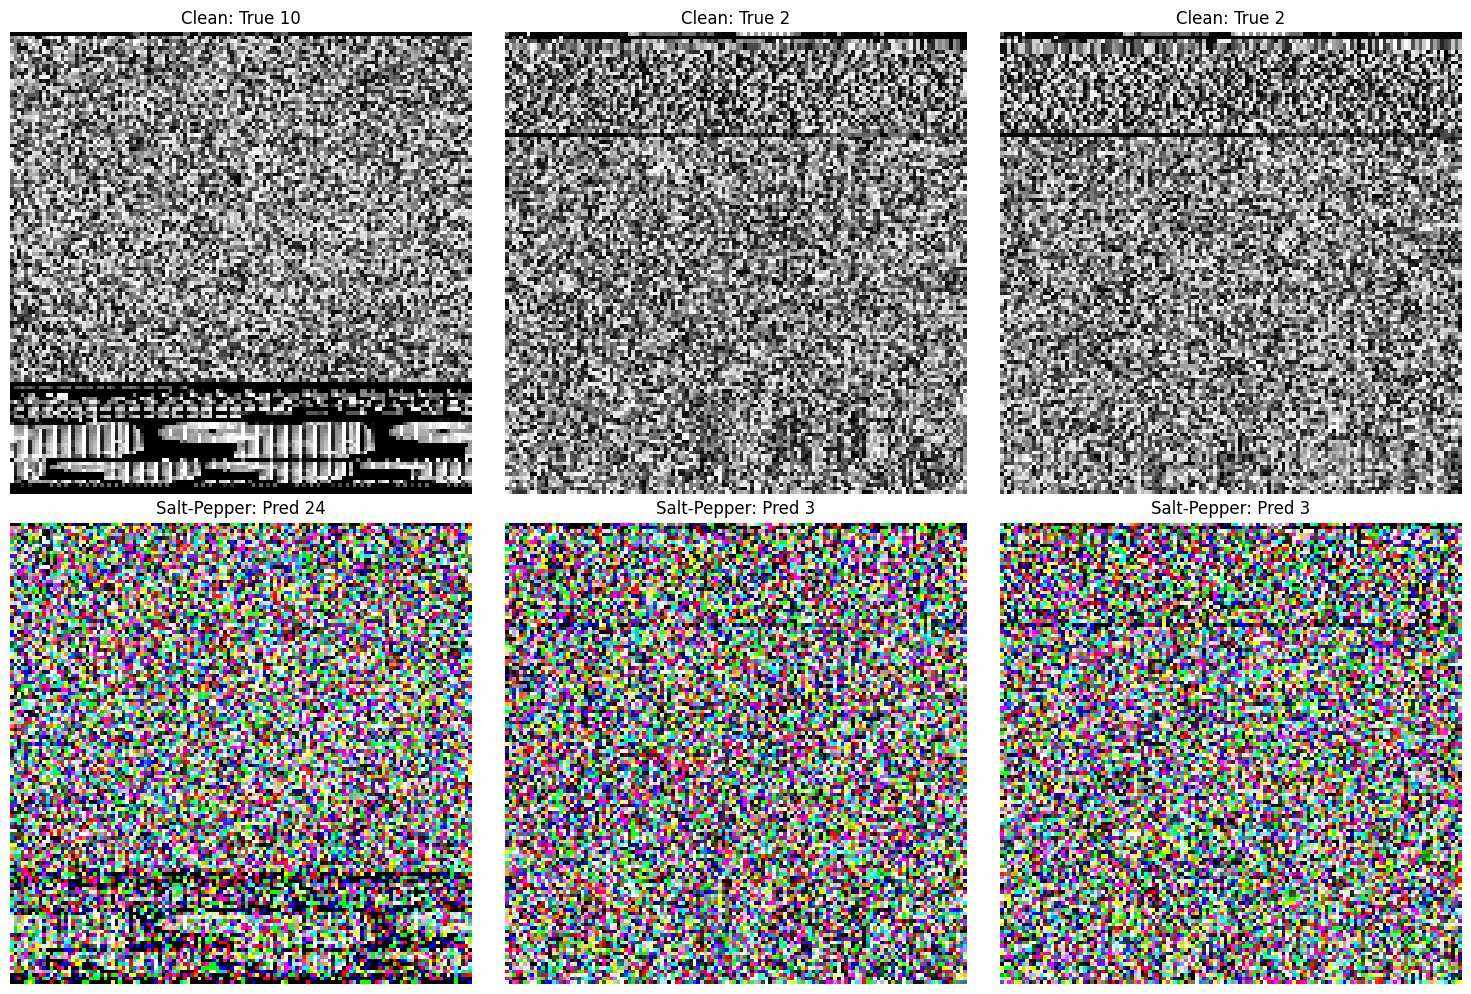

In [ ]:
import numpy as np

def add_salt_pepper_noise(x, noise_ratio=0.6):
    """
    Add Salt-and-Pepper noise to the input data.

    Parameters:
    - x: Input data (numpy array of shape [batch_size, height, width, channels]).
    - noise_ratio: Fraction of pixels to perturb with noise.

    Returns:
    - Perturbed data with salt-and-pepper noise.
    """
    perturbed_data = x.copy()
    batch_size, height, width, channels = x.shape
    num_pixels = int(noise_ratio * height * width * channels)  # Total pixels to perturb

    for i in range(batch_size):
        # Get random pixel indices to perturb
        for _ in range(num_pixels):
            row = np.random.randint(0, height)
            col = np.random.randint(0, width)
            channel = np.random.randint(0, channels)

            # Assign pixel to salt (1) or pepper (0)
            perturbed_data[i, row, col, channel] = 1 if np.random.rand() > 0.5 else 0

    return perturbed_data

# Example Usage
x_test, y_test = next(iter(test_data))  # Load a batch of test data
x_test_subset, y_test_subset = x_test[:100], y_test[:100]  # Use a subset of 100 samples
sp_adv_images = add_salt_pepper_noise(x_test_subset, noise_ratio=0.6)  # Add 60% noise (higher intensity)

# Evaluate the model on noisy data
sp_adv_predictions = classifier.predict(sp_adv_images)

# Compute metrics
true_labels = np.argmax(y_test_subset, axis=1)
sp_adv_labels = np.argmax(sp_adv_predictions, axis=1)
sp_success_rate = np.mean(sp_adv_labels != true_labels) * 100
sp_adv_accuracy = np.mean(sp_adv_labels == true_labels) * 100

print(f"Attack Success Rate (Salt-and-Pepper Noise): {sp_success_rate:.2f}%")
print(f"Adversarial Accuracy (Salt-and-Pepper Noise): {sp_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
num_visualizations = 3  # Visualize 3 samples
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"Salt-Pepper: Pred {sp_adv_labels[i]}")
    plt.imshow(sp_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


# ***HopSkipJump Attack***

HopSkipJump:   0%|          | 0/5 [00:00<?, ?it/s]

Attack Success Rate (HopSkipJump): 80.00%
Adversarial Accuracy (HopSkipJump): 20.00%


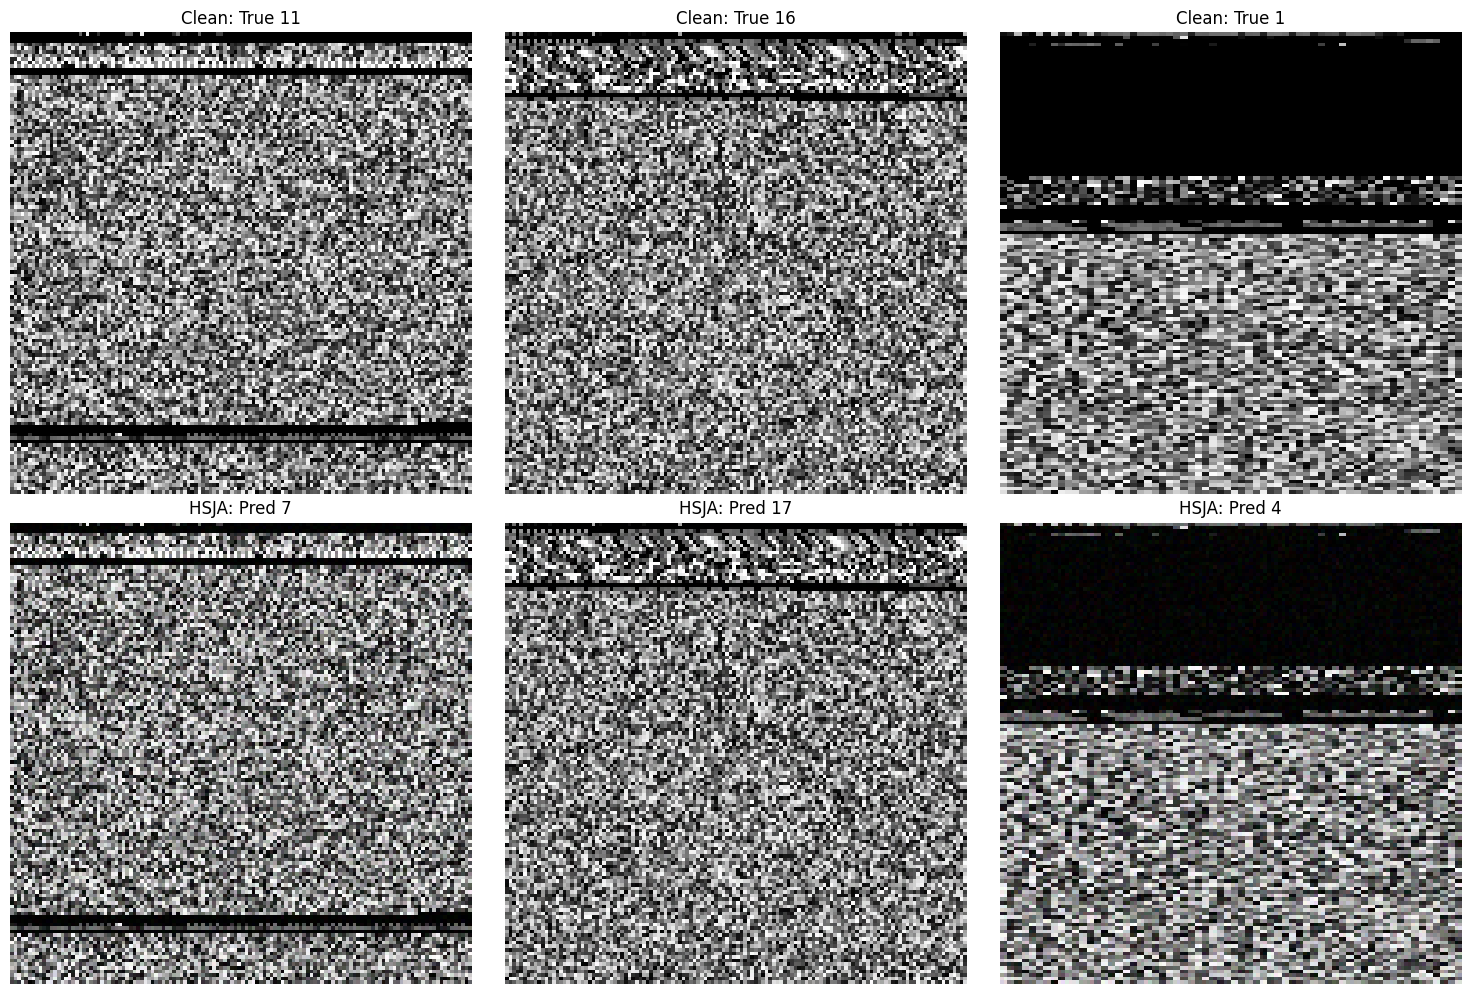

In [ ]:
from art.attacks.evasion import HopSkipJump
import matplotlib.pyplot as plt
import numpy as np

# Perform HopSkipJump Attack
hsja_attack = HopSkipJump(
    classifier=classifier,
    targeted=False,              # Untargeted attack
    max_iter=5,                  # Maximum number of iterations
    max_eval=1000,               # Maximum number of evaluations per iteration
    init_eval=10,                # Initial evaluations to estimate the boundary
    verbose=True                 # Print progress
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:5], y_test[:5]  # Use a smaller subset for the attack

# Generate Adversarial Examples
hsja_adv_images = hsja_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
hsja_adv_predictions = classifier.predict(hsja_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
hsja_adv_labels = np.argmax(hsja_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
hsja_success_rate = np.mean(hsja_adv_labels != true_labels) * 100
hsja_adv_accuracy = np.mean(hsja_adv_labels == true_labels) * 100

print(f"Attack Success Rate (HopSkipJump): {hsja_success_rate:.2f}%")
print(f"Adversarial Accuracy (HopSkipJump): {hsja_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit visualization to 3 samples
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"HSJA: Pred {hsja_adv_labels[i]}")
    plt.imshow(hsja_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


More Subset

HopSkipJump:   0%|          | 0/32 [00:00<?, ?it/s]

Attack Success Rate (HopSkipJump): 75.00%
Adversarial Accuracy (HopSkipJump): 25.00%


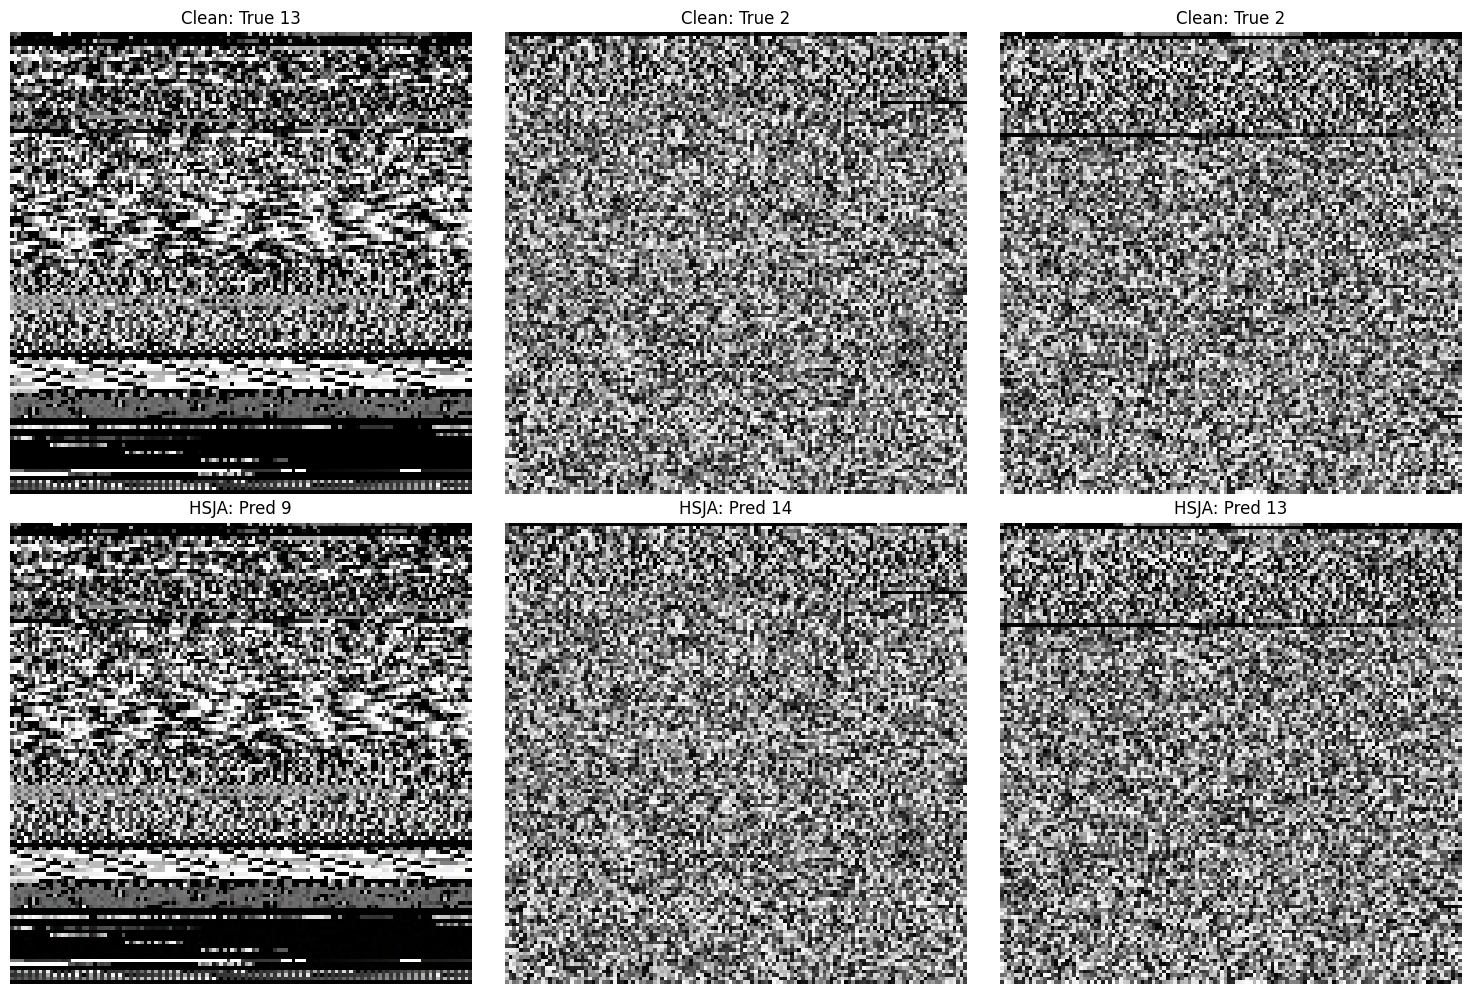

In [ ]:
from art.attacks.evasion import HopSkipJump
import matplotlib.pyplot as plt
import numpy as np

# Perform a More Aggressive HopSkipJump Attack
hsja_attack = HopSkipJump(
    classifier=classifier,
    targeted=False,              # Untargeted attack
    max_iter=10,                 # Increased number of iterations
    max_eval=2000,               # Increased maximum evaluations per iteration
    init_eval=50,                # Increased initial evaluations to refine boundary estimates
    verbose=True                 # Print progress
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:100], y_test[:100]  # Use a subset of 100 samples

# Generate Adversarial Examples
hsja_adv_images = hsja_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
hsja_adv_predictions = classifier.predict(hsja_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
hsja_adv_labels = np.argmax(hsja_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
hsja_success_rate = np.mean(hsja_adv_labels != true_labels) * 100
hsja_adv_accuracy = np.mean(hsja_adv_labels == true_labels) * 100

print(f"Attack Success Rate (HopSkipJump): {hsja_success_rate:.2f}%")
print(f"Adversarial Accuracy (HopSkipJump): {hsja_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit visualization to 3 samples
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"HSJA: Pred {hsja_adv_labels[i]}")
    plt.imshow(hsja_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


HopSkipJump:   0%|          | 0/32 [00:00<?, ?it/s]

Attack Success Rate (HopSkipJump): 84.38%
Adversarial Accuracy (HopSkipJump): 15.62%


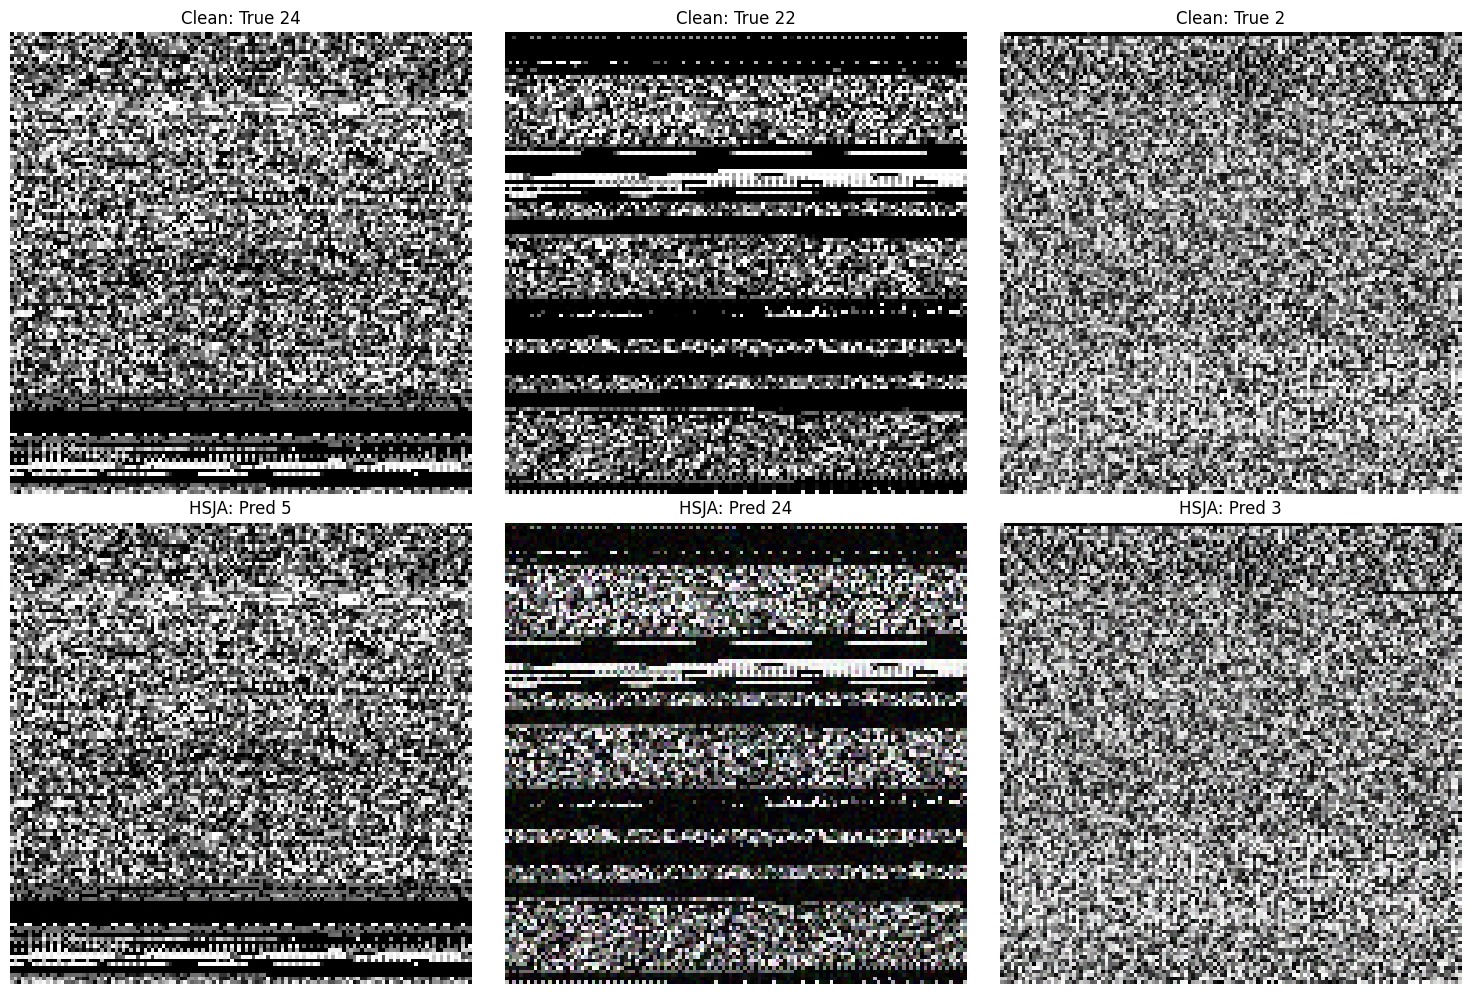

In [ ]:
from art.attacks.evasion import HopSkipJump
import matplotlib.pyplot as plt
import numpy as np

# Perform an Even More Aggressive HopSkipJump Attack
hsja_attack = HopSkipJump(
    classifier=classifier,
    targeted=False,              # Untargeted attack
    max_iter=20,                 # Increase the number of iterations for stronger perturbations
    max_eval=5000,               # Higher maximum evaluations per iteration for thorough exploration
    init_eval=100,               # Increase initial evaluations for better boundary estimation
    verbose=True                 # Display progress of the attack
)

# Sample Test Data
x_test, y_test = next(iter(test_data))
x_test_subset, y_test_subset = x_test[:100], y_test[:100]  # Use a subset of 100 samples

# Generate Adversarial Examples
hsja_adv_images = hsja_attack.generate(x=x_test_subset)

# Evaluate on Adversarial Examples
hsja_adv_predictions = classifier.predict(hsja_adv_images)

# Metrics
true_labels = np.argmax(y_test_subset, axis=1)
hsja_adv_labels = np.argmax(hsja_adv_predictions, axis=1)

# Compute Attack Success Rate and Adversarial Accuracy
hsja_success_rate = np.mean(hsja_adv_labels != true_labels) * 100
hsja_adv_accuracy = np.mean(hsja_adv_labels == true_labels) * 100

print(f"Attack Success Rate (HopSkipJump): {hsja_success_rate:.2f}%")
print(f"Adversarial Accuracy (HopSkipJump): {hsja_adv_accuracy:.2f}%")

# Visualize Clean and Adversarial Images
plt.figure(figsize=(15, 10))
num_visualizations = 3  # Limit visualization to 3 samples
for i in range(num_visualizations):
    # Clean Image
    plt.subplot(2, num_visualizations, i + 1)
    plt.title(f"Clean: True {true_labels[i]}")
    plt.imshow(x_test_subset[i])
    plt.axis('off')

    # Adversarial Image
    plt.subplot(2, num_visualizations, i + 1 + num_visualizations)
    plt.title(f"HSJA: Pred {hsja_adv_labels[i]}")
    plt.imshow(hsja_adv_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()
